In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline

plt.style.use('bmh')
pd.options.display.float_format = '{:,.0f}'.format
pd.set_option("display.max_columns", 40)

## Let's get setup

In [6]:
df = pd.read_csv('../data/fanfics_metadata.csv')

In [7]:
df.comments.mean()

20.28517006802721

In [8]:
df.hits.mean()

1131.404800745747

## Clean data

In [9]:
cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
cols_with_missing

['category',
 'relationship',
 'character',
 'additional tags',
 'words',
 'comments',
 'kudos',
 'bookmarks',
 'hits']

Some columns are blank, but that says something and is not considered missing data. For example NaN in bookmarks means no one has bookmarked that work. Let's add in zeros to be explicit about this. For categorical data, we can deal with NaN when we do one-hot encoding.

In [10]:
df['category'].fillna('No Category Specified', inplace=True)
df['relationship'].fillna('No Relationship Specified', inplace=True)
df['character'].fillna('No Character Specified', inplace=True)
df['additional tags'].fillna('No Additional Tags Specified', inplace=True)
df['words'].fillna(0, inplace=True)
df['comments'].fillna(0, inplace=True)
df['kudos'].fillna(0, inplace=True)
df['bookmarks'].fillna(0, inplace=True)
df['hits'].fillna(0, inplace=True)

Note some authors have opted to hide their hit counts and so setting a value to 0 doesn't necessarily mean that they dont' have hits. We should decide the best way to fill it in. Possibly using the predicted values from a multiple linear regression.

In [48]:
df.loc[df['hits']==0].count()

work_id            29
title              29
rating             29
category           29
fandom             29
relationship       29
character          29
additional tags    29
language           29
published          29
status             29
status date        29
words              29
chapters           29
comments           29
kudos              29
bookmarks          29
hits               29
dtype: int64

We have multiple columns of categories, several of which consists of list of variables ('category', 'fandom', 'relationship', 'additional tags'). The 'category' column is actually fairly short. It can be M/M, F/F, F/M, Gen, Multi, Other, or No Category Specified in some combination. The three other columns are progressively more complicated. 

In [11]:
df['category'].unique()

array(['M/M, F/F', 'Gen', 'F/M, Multi', 'F/F, F/M, M/M', 'F/M',
       'F/M, M/M', 'M/M', 'F/M, Gen, M/M', 'No Category Specified',
       'M/M, Multi', 'Gen, Multi, F/F, F/M, M/M', 'F/F, F/M, M/M, Multi',
       'Gen, M/M, F/M', 'Gen, M/M', 'F/M, Gen', 'F/M, M/M, Multi',
       'F/M, F/F, M/M', 'M/M, F/M', 'F/M, M/M, Multi, F/F', 'F/F',
       'F/M, Other', 'M/M, Other', 'Multi', 'Gen, M/M, Multi',
       'Gen, Multi', 'M/M, F/M, Multi', 'Gen, F/M', 'Gen, Other',
       'Gen, M/M, F/M, F/F', 'M/M, Gen', 'Gen, F/M, M/M', 'Other',
       'M/M, F/F, F/M', 'F/F, M/M', 'F/F, F/M, Gen, Other',
       'M/M, Multi, Other, F/F, F/M, Gen', 'F/F, F/M',
       'F/F, M/M, Multi, Gen, F/M', 'F/F, Gen', 'F/F, F/M, Gen',
       'F/M, Gen, Multi', 'F/M, Gen, M/M, Other', 'F/F, F/M, Multi, M/M',
       'Gen, F/F', 'F/M, Gen, Other', 'F/M, M/M, Multi, Gen',
       'Gen, M/M, Multi, Other', 'F/M, F/F, Multi', 'M/M, F/F, Multi',
       'F/M, Other, F/F, Multi', 'F/M, Gen, F/F, M/M',
       'M/M, F/M, Mult

## Working with Categories

The following are all types of categories that can be one-hot encoded as needed: 'rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags'. Use col_list to specifiy the columns you want in the new data frame and whether you want to drop the original columns.

In [12]:
def column_MLB(col_name, df):
    # Takes a column name and does one-shot encoding on it, indpendent of whether 
    # each row of column is a category or a list of categorical data
    
    mlb = MultiLabelBinarizer()
    #create boolean mask matched non NaNs values
    mask = df[col_name].notnull()
    #filter by boolean indexing
    arr = mlb.fit_transform(df.loc[mask, col_name].dropna().str.strip('[]').str.split(', '))
    #create DataFrame and add missing (NaN)s index values
    return (pd.DataFrame(arr, index=df.index[mask], columns=mlb.classes_)
               .reindex(df.index, fill_value=0))

In [13]:
def one_hot_encoding(df, columns, drop):
    df_one_hot_encoded = df
    for column in columns:
        result = column_MLB(column, df)
        df_one_hot_encoded = pd.concat([df_one_hot_encoded, result], axis=1, sort=False)
        if drop == True:
            df_one_hot_encoded.drop([column],axis=1, inplace=True)
          
    return df_one_hot_encoded
    

In [14]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['category']
new_df = one_hot_encoding(df, col_list, drop=True)
new_df

,work_id,title,rating,fandom,relationship,character,additional tags,language,published,status,status date,words,chapters,comments,kudos,bookmarks,hits,F/F,F/M,Gen,M/M,Multi,No Category Specified,Other
0,3104510,Second Chances,Teen And Up Audiences,"Star Wars - All Media Types, Star Wars Prequel...","Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenob...","Leia Organa, Luke Skywalker, Anakin Skywalker,...","Age Regression/De-Aging, Soul Bond, The Force,...",English,2015-01-05,Completed,2016-04-16,"121,358",42/42,803,"1,917",446,"74,424",1,0,0,1,0,0,0
1,6423526,hurricane on the edge of oblivion (with nowher...,Mature,Star Wars: The Wrath of Darth Maul - Ryder Win...,"Obi-Wan Kenobi & Xanatos, Qui-Gon Jinn & Feemo...","Obi-Wan Kenobi, Xanatos (Star Wars), Qui-Gon J...","minor OC's - Freeform, at least I'm pretty sur...",English,2016-04-01,Updated,2019-12-23,"144,982",24/?,744,"1,815",380,"28,728",0,0,1,0,0,0,0
2,9552773,time to change the road you're on,General Audiences,"Star Wars - All Media Types, Star Wars: The Cl...","Anakin Skywalker & Ahsoka Tano, Ahsoka Tano an...","Ahsoka Tano, Anakin Skywalker, Kanan Jarrus, E...","AU, Time Travel Fix-It, possibly more of a tim...",English,2017-02-02,Completed,2017-12-27,"37,400",8/8,234,"1,446",340,"25,348",0,0,1,0,0,0,0
3,5162474,Twin Sunrise,General Audiences,"Star Wars Original Trilogy, Star Wars: Rebels,...","Luke Skywalker & Darth Vader, Darth Vader & Ap...","Anakin Skywalker | Darth Vader, Luke Skywalker...","Grey Jedi, Alternate Universe, Sith Shenanigan...",English,2015-11-07,Completed,2018-01-14,"302,486",55/55,"1,003","1,418",382,"52,527",0,0,1,0,0,0,0
4,4417469,On the Edge of the Devil's Backbone,Teen And Up Audiences,"Star Wars: Rebels, Star Wars - All Media Types",Kanan Jarrus/Hera Syndulla,"Hera Syndulla, Kanan Jarrus, Sabine Wren, Gara...","Alternate Universe, Canon-Typical Violence",English,2015-07-25,Completed,2018-10-20,"361,502",30/30,675,"1,395",255,"39,386",0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,17114495,Ostateczne Poswiecenie. Nieznana historia ukry...,General Audiences,"Star Wars - All Media Types, Rogue One: A Star...",No Relationship Specified,"Wilhuff Tarkin, Ahsoka Tano, Wulff Yularen",No Additional Tags Specified,Polski,2018-12-23,Completed,2018-12-22,"5,462",2/2,0,0,0,41,0,0,1,0,0,0,0
4316,16719585,The Life of Scoundrels,General Audiences,"Star Wars Sequel Trilogy, Star Wars Rebels",No Relationship Specified,"Han Solo, Chewbacca (Star Wars), Boba Fett, Ho...","disintegrations WILL become part of your rep, ...",English,2018-11-23,Completed,2018-11-23,"5,587",12/12,0,0,0,61,0,0,1,0,0,0,0
4317,20451119,In Night,Mature,"Star Wars: Rebels, Star Wars:KANAN",Janus Kasmir/Caleb Dume,"Caleb Dume, Janus Kasmir",No Additional Tags Specified,Ri Ben Yu,2019-08-30,Completed,2019-08-30,"5,424",1/1,0,0,0,15,0,0,0,1,0,0,0
4318,17136161,"""I am my prayer to you""",General Audiences,Star Wars: Rebels,"Garazeb ""Zeb"" Orrelios/Original Character(s)","Garazeb ""Zeb"" Orrelios, Original Characters","Romance, Religion, Lasan, Lasat, Prayer, Pilgr...",English,2018-12-24,Completed,2018-12-24,"1,842",1/1,0,0,0,46,0,1,0,0,0,0,0


Some general notes. One hot encoding all the categories will result in over 15k features, and a very sparse matrix. 

AO3 actually allows users to tag things as they like but a human will assign synonyms as they see fit. Its an unusual and powerful hyrbrid. Using the synonyms instead of user specified tag might result in a reduction of columns by perhaps a third? I'm not really sure without further scraping and possibly a database. For the near term, working to explore the data further might be most helpful.

## Shape of the Data - Univariate Analysis

### Interactions and Rating

In [15]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['rating']
rating_df = one_hot_encoding(df, col_list, drop=True)
rating_df

,work_id,title,category,fandom,relationship,character,additional tags,language,published,status,status date,words,chapters,comments,kudos,bookmarks,hits,Explicit,General Audiences,Mature,Not Rated,Teen And Up Audiences
0,3104510,Second Chances,"M/M, F/F","Star Wars - All Media Types, Star Wars Prequel...","Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenob...","Leia Organa, Luke Skywalker, Anakin Skywalker,...","Age Regression/De-Aging, Soul Bond, The Force,...",English,2015-01-05,Completed,2016-04-16,"121,358",42/42,803,"1,917",446,"74,424",0,0,0,0,1
1,6423526,hurricane on the edge of oblivion (with nowher...,Gen,Star Wars: The Wrath of Darth Maul - Ryder Win...,"Obi-Wan Kenobi & Xanatos, Qui-Gon Jinn & Feemo...","Obi-Wan Kenobi, Xanatos (Star Wars), Qui-Gon J...","minor OC's - Freeform, at least I'm pretty sur...",English,2016-04-01,Updated,2019-12-23,"144,982",24/?,744,"1,815",380,"28,728",0,0,1,0,0
2,9552773,time to change the road you're on,Gen,"Star Wars - All Media Types, Star Wars: The Cl...","Anakin Skywalker & Ahsoka Tano, Ahsoka Tano an...","Ahsoka Tano, Anakin Skywalker, Kanan Jarrus, E...","AU, Time Travel Fix-It, possibly more of a tim...",English,2017-02-02,Completed,2017-12-27,"37,400",8/8,234,"1,446",340,"25,348",0,1,0,0,0
3,5162474,Twin Sunrise,Gen,"Star Wars Original Trilogy, Star Wars: Rebels,...","Luke Skywalker & Darth Vader, Darth Vader & Ap...","Anakin Skywalker | Darth Vader, Luke Skywalker...","Grey Jedi, Alternate Universe, Sith Shenanigan...",English,2015-11-07,Completed,2018-01-14,"302,486",55/55,"1,003","1,418",382,"52,527",0,1,0,0,0
4,4417469,On the Edge of the Devil's Backbone,"F/M, Multi","Star Wars: Rebels, Star Wars - All Media Types",Kanan Jarrus/Hera Syndulla,"Hera Syndulla, Kanan Jarrus, Sabine Wren, Gara...","Alternate Universe, Canon-Typical Violence",English,2015-07-25,Completed,2018-10-20,"361,502",30/30,675,"1,395",255,"39,386",0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,17114495,Ostateczne Poswiecenie. Nieznana historia ukry...,Gen,"Star Wars - All Media Types, Rogue One: A Star...",No Relationship Specified,"Wilhuff Tarkin, Ahsoka Tano, Wulff Yularen",No Additional Tags Specified,Polski,2018-12-23,Completed,2018-12-22,"5,462",2/2,0,0,0,41,0,1,0,0,0
4316,16719585,The Life of Scoundrels,Gen,"Star Wars Sequel Trilogy, Star Wars Rebels",No Relationship Specified,"Han Solo, Chewbacca (Star Wars), Boba Fett, Ho...","disintegrations WILL become part of your rep, ...",English,2018-11-23,Completed,2018-11-23,"5,587",12/12,0,0,0,61,0,1,0,0,0
4317,20451119,In Night,M/M,"Star Wars: Rebels, Star Wars:KANAN",Janus Kasmir/Caleb Dume,"Caleb Dume, Janus Kasmir",No Additional Tags Specified,Ri Ben Yu,2019-08-30,Completed,2019-08-30,"5,424",1/1,0,0,0,15,0,0,1,0,0
4318,17136161,"""I am my prayer to you""",F/M,Star Wars: Rebels,"Garazeb ""Zeb"" Orrelios/Original Character(s)","Garazeb ""Zeb"" Orrelios, Original Characters","Romance, Religion, Lasan, Lasat, Prayer, Pilgr...",English,2018-12-24,Completed,2018-12-24,"1,842",1/1,0,0,0,46,0,1,0,0,0


In [16]:
def plot_rating_interactions(metric, ylim):
    general = rating_df[rating_df['General Audiences'] == 1][metric].values
    teen = rating_df[rating_df['Teen And Up Audiences'] == 1][metric].values
    mature = rating_df[rating_df['Mature'] == 1][metric].values
    explicit = rating_df[rating_df['Explicit'] == 1][metric].values
    unrated = rating_df[rating_df['Not Rated'] == 1][metric].values

    data_to_plot = [general, teen, mature, explicit, unrated]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['General', 'Teen', 'Mature', 'Explicit', 'Not Rated'])
    ax.set_xlabel(metric + ' and Ratings')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

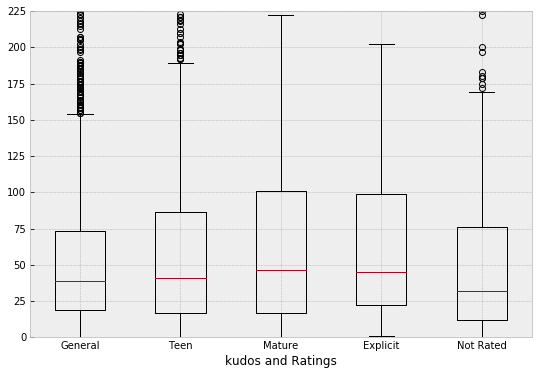

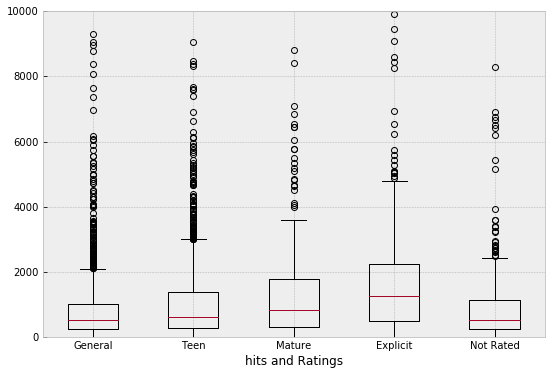

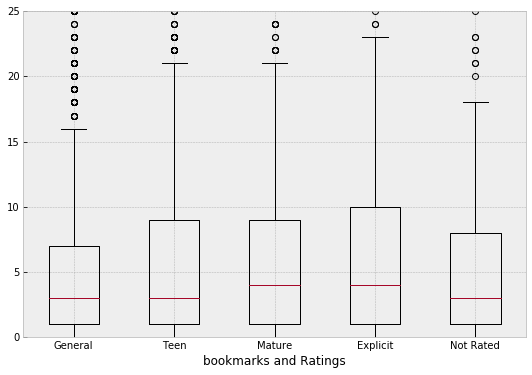

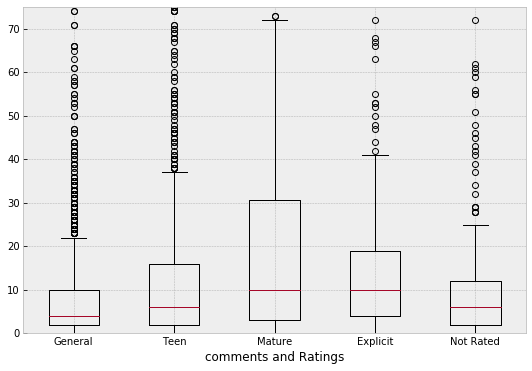

In [17]:
plot_rating_interactions('kudos', 225)
plot_rating_interactions('hits', 10000)
plot_rating_interactions('bookmarks', 25)
plot_rating_interactions('comments', 75)

### Interactions and AO3 Categories


In [18]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['category']
cat_df = one_hot_encoding(df, col_list, drop=True)
cat_df.sum(axis = 0, skipna = True)


work_id                                                        54967815182
title                    Second Chanceshurricane on the edge of oblivio...
rating                   Teen And Up AudiencesMatureGeneral AudiencesGe...
fandom                   Star Wars - All Media Types, Star Wars Prequel...
relationship             Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenob...
character                Leia Organa, Luke Skywalker, Anakin Skywalker,...
additional tags          Age Regression/De-Aging, Soul Bond, The Force,...
language                 EnglishEnglishEnglishEnglishEnglishEnglishEngl...
published                2015-01-052016-04-012017-02-022015-11-072015-0...
status                   CompletedUpdatedCompletedCompletedCompletedCom...
status date              2016-04-162019-12-232017-12-272018-01-142018-1...
words                                                           34,627,299
chapters                 42/4224/?8/855/5530/301/117/171/145/451/11/15/...
comments                 

In [19]:
def plot_cat_interactions(metric, ylim):

    np_ar1 = cat_df[cat_df['Gen'] == 1][metric].values
    np_ar2 = cat_df[cat_df['F/M'] == 1][metric].values
    np_ar3 = cat_df[cat_df['F/F'] == 1][metric].values
    np_ar4 = cat_df[cat_df['M/M'] == 1][metric].values
    np_ar5 = cat_df[cat_df['Multi'] == 1][metric].values
    np_ar6 = cat_df[cat_df['Other'] == 1][metric].values
    np_ar7 = cat_df[cat_df['No Category Specified'] == 1][metric].values

    
    data_to_plot = [np_ar1, np_ar2, np_ar3, np_ar4, np_ar5, np_ar6, np_ar7]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['Gen', 'F/M','F/F', 'M/M', 'Multi', 'Other', 'No Category Specified'])
    ax.set_xlabel(metric + ' and Categories')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

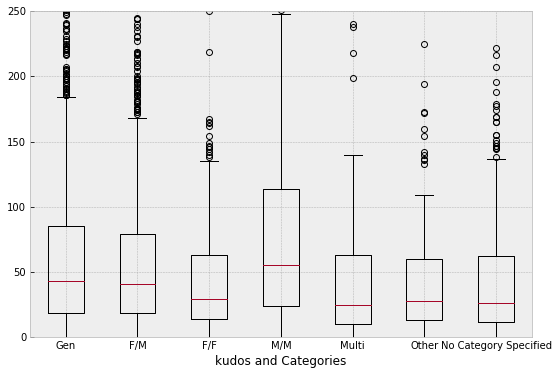

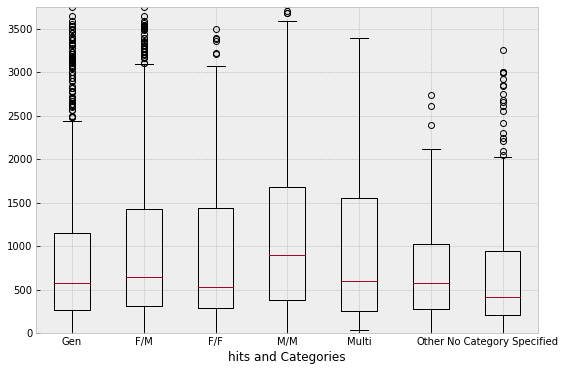

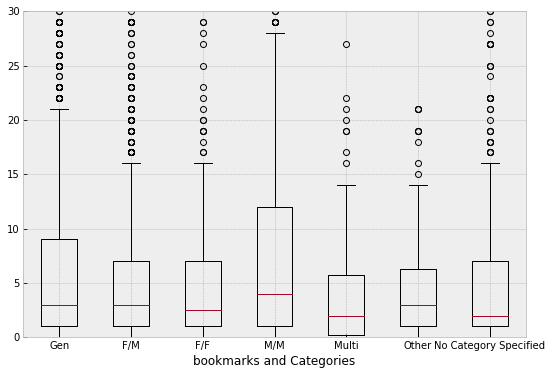

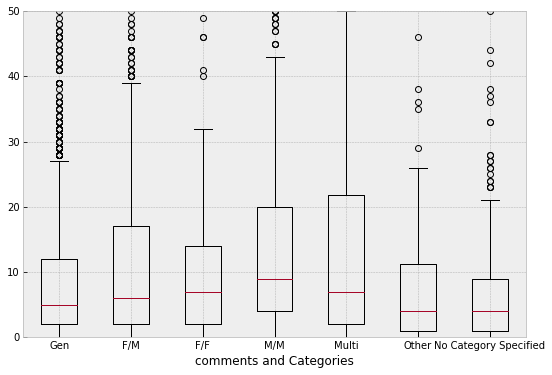

In [20]:
plot_cat_interactions('kudos', 250)
plot_cat_interactions('hits', 3750)
plot_cat_interactions('bookmarks', 30)
plot_cat_interactions('comments', 50)

### Interactions and Fandom

In [21]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['fandom']
fandom_df = one_hot_encoding(df, col_list, drop=True)
#fandom_df.sum(axis = 0, skipna = True)
#fandom_df[fandom_df.columns[-49:]].sum()


In [22]:
def plot_fandom_interactions(metric, ylim):
    # Fandoms > 50
    ['Rogue One: A Star Wars Story (2016)', 
     'Star Wars - All Media Types', 
     'Star Wars Legends - All Media Types', 
     'Star Wars Original Trilogy', 
     'Star Wars Prequel Trilogy', 
     'Star Wars Sequel Trilogy', 
     'Star Wars: A New Dawn - John Jackson Miller', 
     'Star Wars: Clone Wars (2003) - All Media Types', 
     'Star Wars: Rebellion Era - All Media Types', 
     'Star Wars: Rebels', 
     'Star Wars: The Clone Wars (2008) - All Media Types', 
     'Star Wars: Thrawn - Timothy Zahn', 
     'Star Wars: Thrawn Series - Timothy Zahn (2017)'] 

    np_ar1 = fandom_df[fandom_df['Rogue One: A Star Wars Story (2016)'] == 1][metric].values
    np_ar2 = fandom_df[fandom_df['Star Wars - All Media Types'] == 1][metric].values
    np_ar3 = fandom_df[fandom_df['Star Wars Legends - All Media Types'] == 1][metric].values
    np_ar4 = fandom_df[fandom_df['Star Wars Original Trilogy'] == 1][metric].values
    np_ar5 = fandom_df[fandom_df['Star Wars Prequel Trilogy'] == 1][metric].values
    np_ar6 = fandom_df[fandom_df['Star Wars Sequel Trilogy'] == 1][metric].values
    np_ar7 = fandom_df[fandom_df['Star Wars: A New Dawn - John Jackson Miller'] == 1][metric].values
    np_ar8 = fandom_df[fandom_df['Star Wars: Clone Wars (2003) - All Media Types'] == 1][metric].values
    np_ar9 = fandom_df[fandom_df['Star Wars: Rebellion Era - All Media Types'] == 1][metric].values
    np_ar10 = fandom_df[fandom_df['Star Wars: Rebels'] == 1][metric].values
    np_ar11 = fandom_df[fandom_df['Star Wars: The Clone Wars (2008) - All Media Types'] == 1][metric].values
    np_ar12 = fandom_df[fandom_df['Star Wars: Thrawn - Timothy Zahn'] == 1][metric].values    
    np_ar13 = fandom_df[fandom_df['Star Wars: Thrawn Series - Timothy Zahn (2017)'] == 1][metric].values
  
    data_to_plot = [np_ar1, np_ar2, np_ar3, np_ar4, np_ar5, 
                    np_ar6, np_ar7, np_ar8, np_ar9, np_ar10, 
                    np_ar11, np_ar12, np_ar13]

    # Create a figure instance
    fig = plt.figure(1, figsize=(25, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['Rogue', 
     'SW-All', 
     'SWL-All', 
     'SW OT', 
     'SW PT', 
     'SW ST', 
     'SW AND', 
     'SWCW 2003', 
     'SW Reb Era', 
     'SWR', 
     'SWCW 2008', 
     'Thrawn', 
     'Thrawn Series 2017'])
    ax.set_xlabel(metric + ' and Fandoms')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

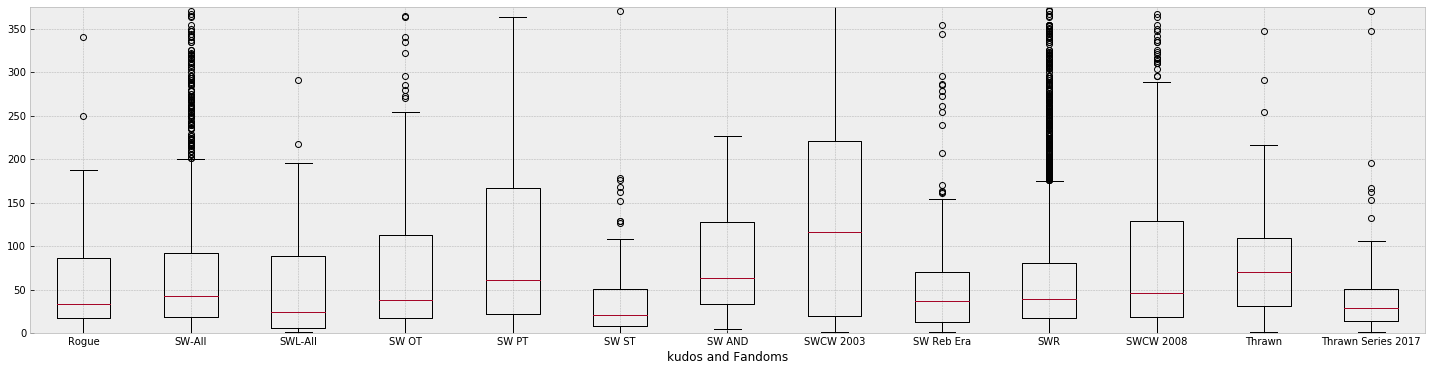

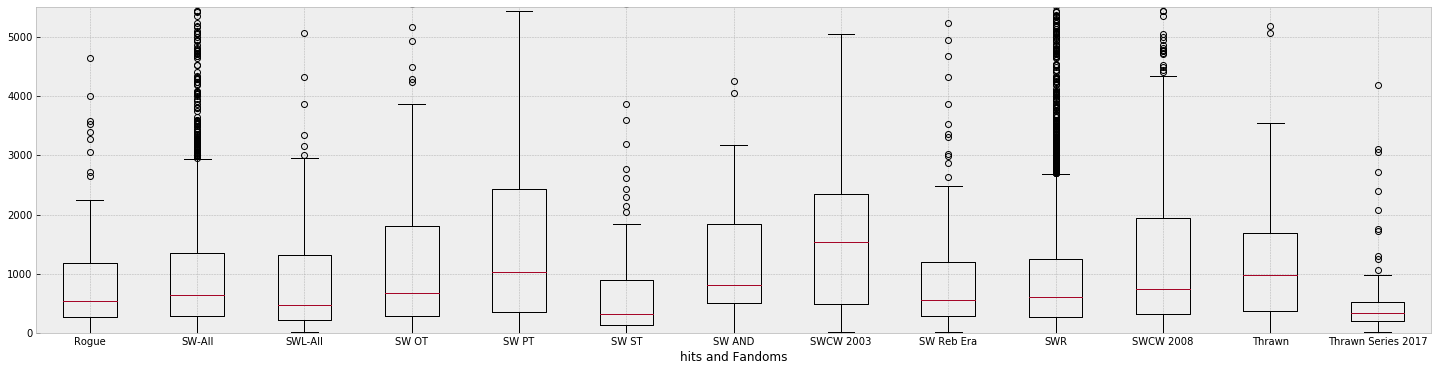

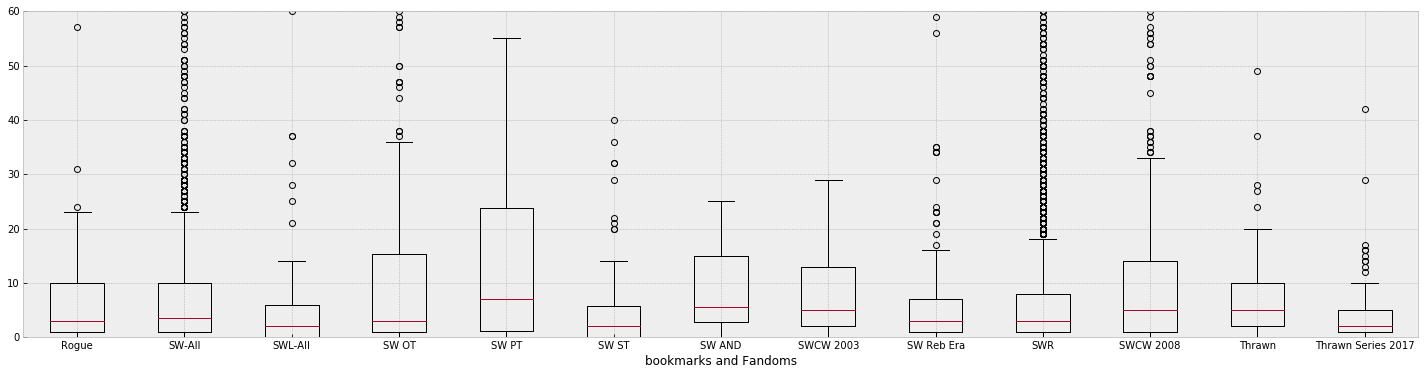

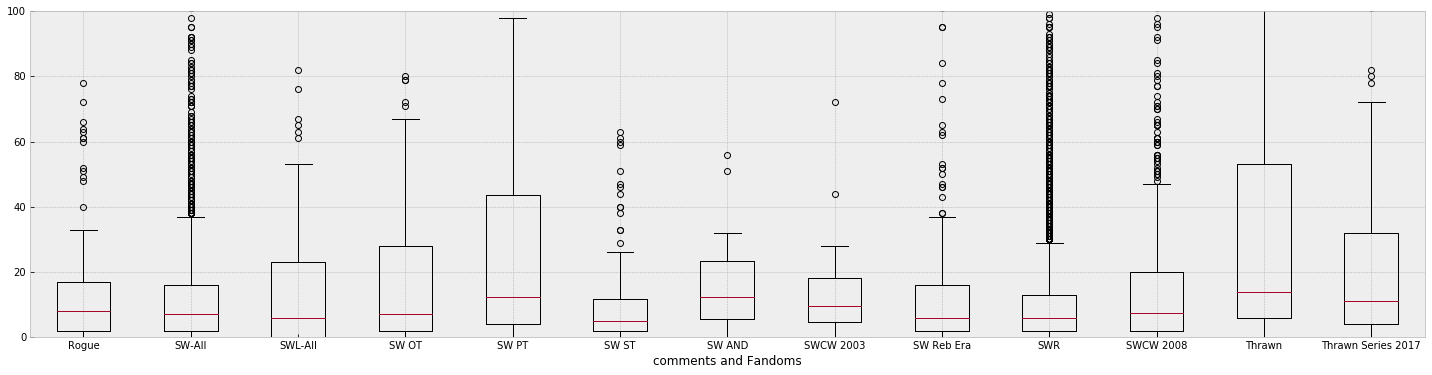

In [23]:
plot_fandom_interactions('kudos', 375)
plot_fandom_interactions('hits', 5500)
plot_fandom_interactions('bookmarks', 60)
plot_fandom_interactions('comments', 100)

### Interactions and Relationship

In [24]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['relationship']
relationship_df = one_hot_encoding(df, col_list, drop=True)
#relationship_df.sum(axis = 0, skipna = True)
#relationship_df[relationship_df.columns[-240:-180]].sum()

In [25]:
  def plot_relationship_interactions(metric, ylim):
    # Ships more than 50
    long_ship_list = ['Ahsoka Tano & Darth Vader ', 'Alexsandr Kallus/Garazeb "Zeb" Orrelios', 'Anakin Skywalker & Ahsoka Tano',
     "Arihnda Pryce/Thrawn | Mitth'raw'nuruodo ", 'CT-7567 | Rex/Ahsoka Tano', 'Ezra Bridger & Darth Maul', 
     'Ezra Bridger & Kanan Jarrus', 'Ezra Bridger & Sabine Wren', 'Ezra Bridger/Kanan Jarrus', 
     'Ezra Bridger/Luke Skywalker', 'Ezra Bridger/Sabine Wren', 'Hera Syndulla & Jacen Syndulla', 
     'Hera Syndulla & Sabine Wren', 'Kallus | ISB-021/Garazeb "Zeb" Orrelios', 'Kanan Jarrus & Hera Syndulla',
     'Kanan Jarrus/Hera Syndulla', 'Ketsu Onyo/Sabine Wren', 'Leia Organa/Han Solo', 'No Relationship Specified', 
     'Space Family (Star Wars Rebels)']
    
    #ships more than 100
    short_ship_list =  ['Alexsandr Kallus/Garazeb "Zeb" Orrelios', 'Anakin Skywalker & Ahsoka Tano',
                         'Ezra Bridger & Kanan Jarrus', 'Ezra Bridger & Sabine Wren ', 'Ezra Bridger/Sabine Wren', 
                         'Kallus | ISB-021/Garazeb "Zeb" Orrelios', 'Kanan Jarrus & Hera Syndulla',
                         'Kanan Jarrus/Hera Syndulla', 'No Relationship Specified', 'Space Family (Star Wars Rebels)']

    np_ar1 = relationship_df[relationship_df['Alexsandr Kallus/Garazeb "Zeb" Orrelios'] == 1][metric].values
    np_ar2 = relationship_df[relationship_df['Anakin Skywalker & Ahsoka Tano'] == 1][metric].values
    np_ar3 = relationship_df[relationship_df['Ezra Bridger & Kanan Jarrus'] == 1][metric].values
    np_ar4 = relationship_df[relationship_df['Ezra Bridger & Sabine Wren'] == 1][metric].values
    np_ar5 = relationship_df[relationship_df['Ezra Bridger/Sabine Wren'] == 1][metric].values
    np_ar6 = relationship_df[relationship_df['Kallus | ISB-021/Garazeb "Zeb" Orrelios'] == 1][metric].values
    np_ar7 = relationship_df[relationship_df['Kanan Jarrus & Hera Syndulla'] == 1][metric].values
    np_ar8 = relationship_df[relationship_df['Kanan Jarrus/Hera Syndulla'] == 1][metric].values
    np_ar9 = relationship_df[relationship_df['No Relationship Specified'] == 1][metric].values
    np_ar10 = relationship_df[relationship_df['Space Family (Star Wars Rebels)'] == 1][metric].values
    
    data_to_plot = [np_ar1, np_ar2, np_ar3, np_ar4, np_ar5, np_ar6, np_ar7, np_ar8, np_ar9, np_ar10]

    # Create a figure instance
    fig = plt.figure(1, figsize=(25, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['Garazeb-Post', 'Anakin & Ahsoka','Ezra & Kanan', 'Ezra & Sabine', 'Sabreza', 
                         'Garazeb-Pre', 'Kanan & Hera', 'Kanera', 'None', 'Space Family'])
    ax.set_xlabel(metric + ' and Relationships')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()
    


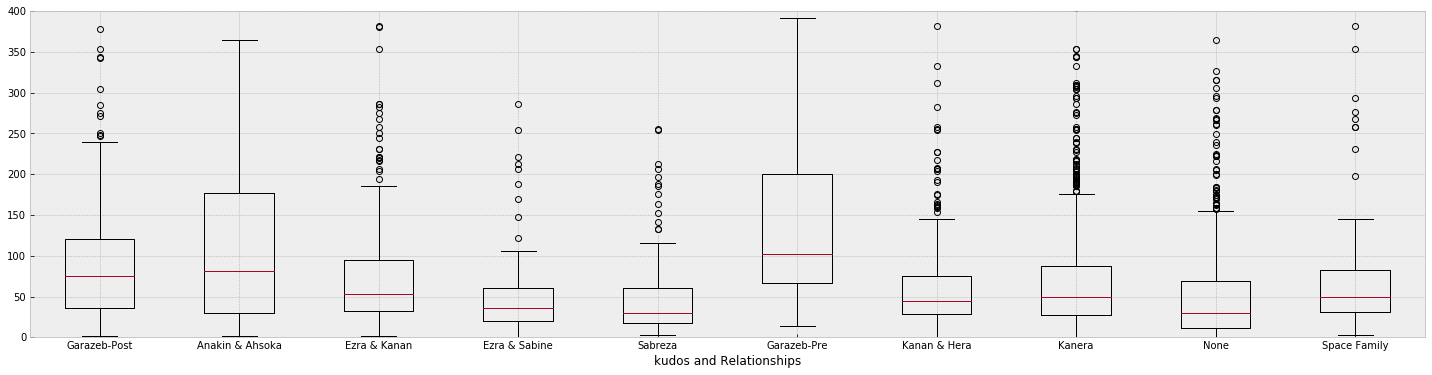

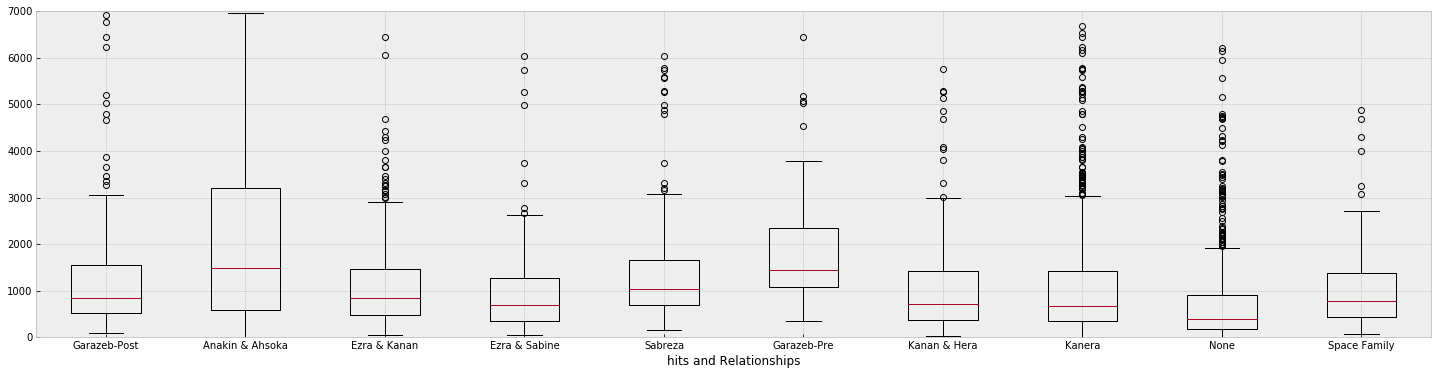

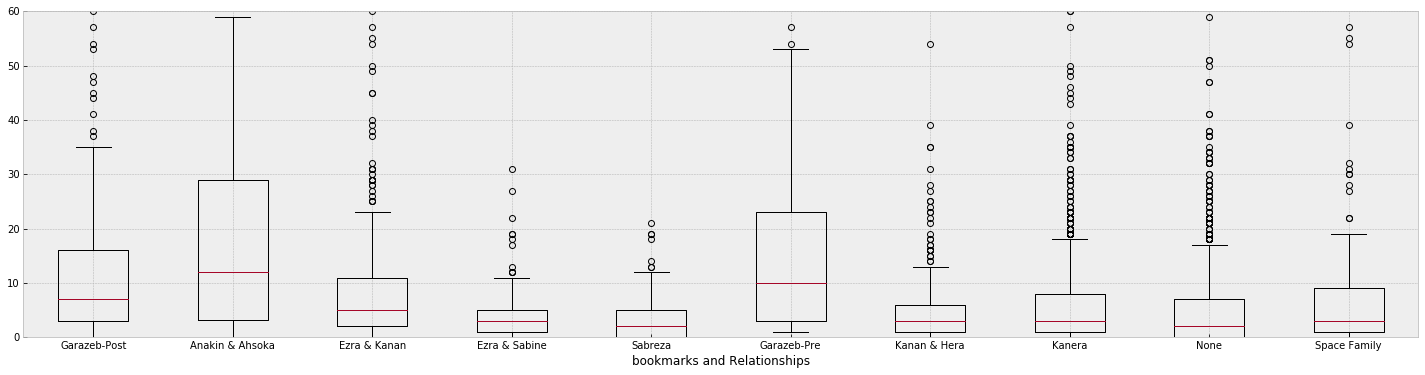

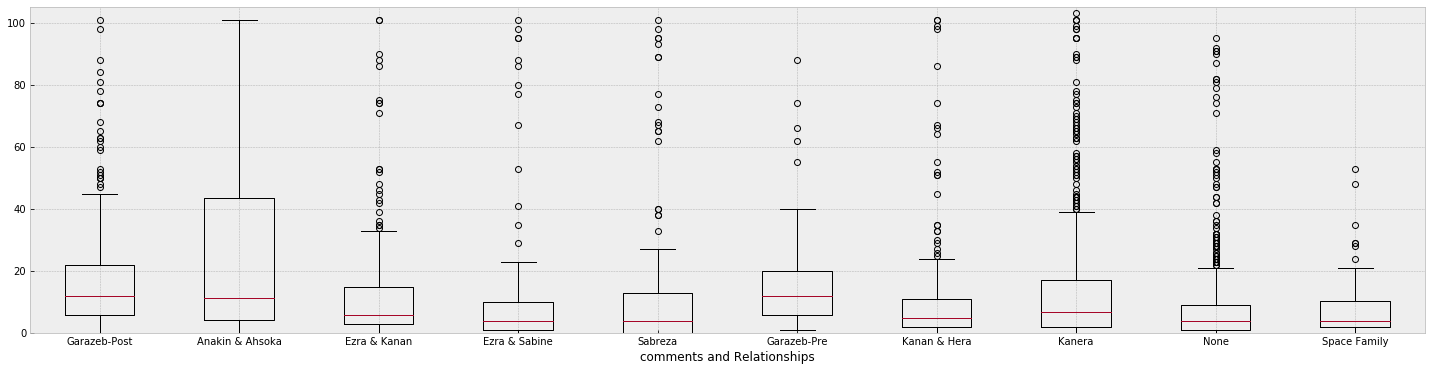

In [26]:
plot_relationship_interactions('kudos', 400)
plot_relationship_interactions('hits', 7000)
plot_relationship_interactions('bookmarks', 60)
plot_relationship_interactions('comments', 105)

### Interactions and Languages

In [27]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['language']
language_df = one_hot_encoding(df, col_list, drop=True)
language_df.sum(axis = 0, skipna = True)



work_id                                                  54967815182
title              Second Chanceshurricane on the edge of oblivio...
rating             Teen And Up AudiencesMatureGeneral AudiencesGe...
category           M/M, F/FGenGenGenF/M, MultiF/F, F/M, M/MF/MGen...
fandom             Star Wars - All Media Types, Star Wars Prequel...
relationship       Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenob...
character          Leia Organa, Luke Skywalker, Anakin Skywalker,...
additional tags    Age Regression/De-Aging, Soul Bond, The Force,...
published          2015-01-052016-04-012017-02-022015-11-072015-0...
status             CompletedUpdatedCompletedCompletedCompletedCom...
status date        2016-04-162019-12-232017-12-272018-01-142018-1...
words                                                     34,627,299
chapters           42/4224/?8/855/5530/301/117/171/145/451/11/15/...
comments                                                      74,548
kudos                             

In [28]:
def plot_language_interactions(metric, ylim):
    # Top 3 languages

    np_ar1 = language_df[language_df['English'] == 1][metric].values
    np_ar2 = language_df[language_df['Polski'] == 1][metric].values
    np_ar3 = language_df[language_df['Russkii'] == 1][metric].values

    
    data_to_plot = [np_ar1, np_ar2, np_ar3]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['English', 'Polski','Russkii'])
    ax.set_xlabel(metric + ' and Languages')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

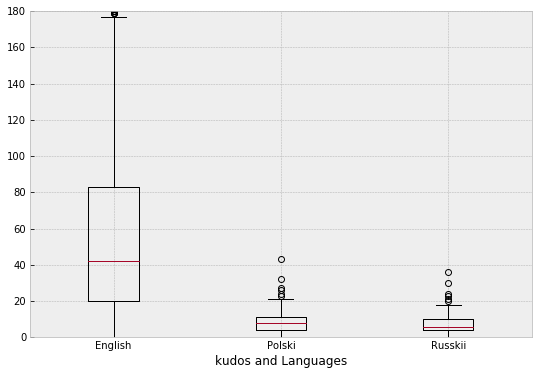

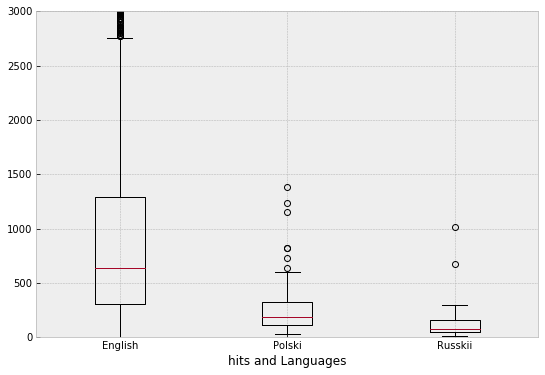

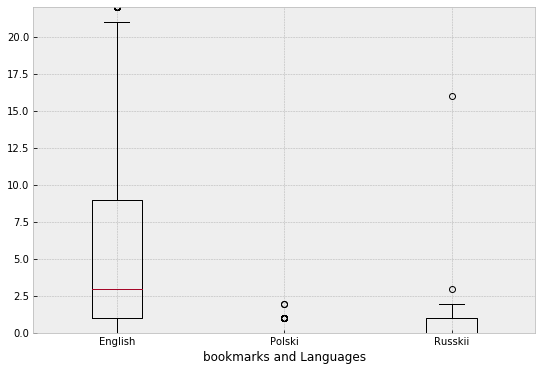

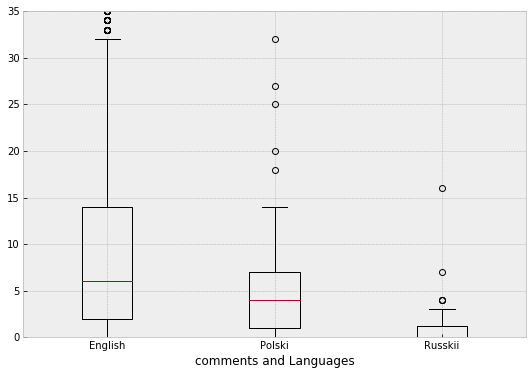

In [29]:
plot_language_interactions('kudos', 180)
plot_language_interactions('hits', 3000)
plot_language_interactions('bookmarks', 22)
plot_language_interactions('comments', 35)

### Interactions and Character

In [30]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['character']
character_df = one_hot_encoding(df, col_list, drop=True)

#character_df.sum(axis = 0, skipna = True)
#character_df[character_df.columns[-60:]].sum()

In [31]:
def plot_character_interactions(metric, ylim):
    # chars > 200
    chars = ['Ahsoka Tano', 'Alexsandr Kallus', 'Anakin Skywalker', 'Anakin Skywalker | Darth Vader',
             'C1-10P | Chopper', 'CT-7567 | Rex', 'Darth Maul', 'Ezra Bridger', 'Garazeb "Zeb" Orrelios',
             'Hera Syndulla', 'Jacen Syndulla', 'Kanan Jarrus', 'Leia Organa', 'Luke Skywalker', 
             'Obi-Wan Kenobi', 'Original Characters', 'Sabine Wren', "Thrawn | Mitth'raw'nuruodo"]

    np_ar1 = character_df[character_df['Ahsoka Tano'] == 1][metric].values
    np_ar2 = character_df[character_df['Alexsandr Kallus'] == 1][metric].values
    np_ar3 = character_df[character_df['Anakin Skywalker'] == 1][metric].values
    np_ar4 = character_df[character_df['Anakin Skywalker | Darth Vader'] == 1][metric].values
    np_ar5 = character_df[character_df['C1-10P | Chopper'] == 1][metric].values
    np_ar6 = character_df[character_df['CT-7567 | Rex'] == 1][metric].values
    np_ar7 = character_df[character_df['Darth Maul'] == 1][metric].values
    np_ar8 = character_df[character_df['Ezra Bridger'] == 1][metric].values
    np_ar9 = character_df[character_df['Garazeb "Zeb" Orrelios'] == 1][metric].values
    np_ar10 = character_df[character_df['Hera Syndulla'] == 1][metric].values
    np_ar11 = character_df[character_df['Jacen Syndulla'] == 1][metric].values
    np_ar12 = character_df[character_df['Kanan Jarrus'] == 1][metric].values
    np_ar13 = character_df[character_df['Leia Organa'] == 1][metric].values
    np_ar14 = character_df[character_df['Luke Skywalker'] == 1][metric].values
    np_ar15 = character_df[character_df['Obi-Wan Kenobi'] == 1][metric].values
    np_ar16 = character_df[character_df['Original Characters'] == 1][metric].values
    np_ar17 = character_df[character_df['Sabine Wren'] == 1][metric].values
    np_ar18 = character_df[character_df["Thrawn | Mitth'raw'nuruodo"] == 1][metric].values

    
    data_to_plot = [np_ar1, np_ar2, np_ar3, np_ar4, np_ar5, np_ar6, np_ar7, np_ar8, np_ar9, np_ar10,
                   np_ar11, np_ar12, np_ar13, np_ar14, np_ar15, np_ar16, np_ar17, np_ar18]

    # Create a figure instance
    fig = plt.figure(1, figsize=(30, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['Ahsoka', 'Kallus', 'Anakin', 'Vader','Chopper', 'Rex', 'Maul', 'Ezra',
                        'Zeb','Hera', 'Jacen', 'Kanan', 'Leia', 'Luke', 'Obi-Wan', 'OC', 'Sabine', 
                        "Thrawn"])
    ax.set_xlabel(metric + ' and Characters')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

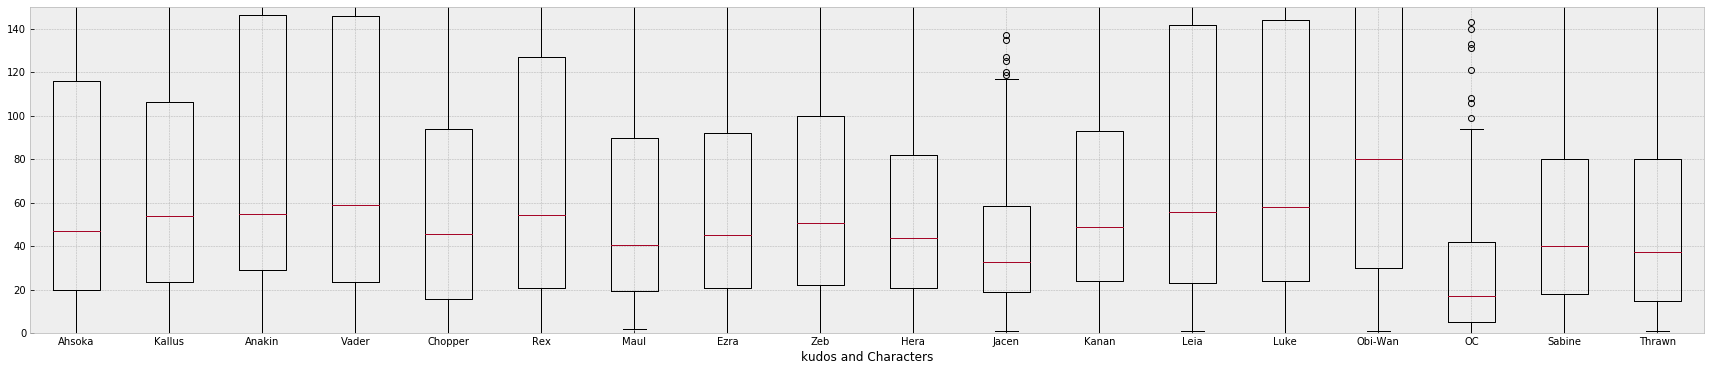

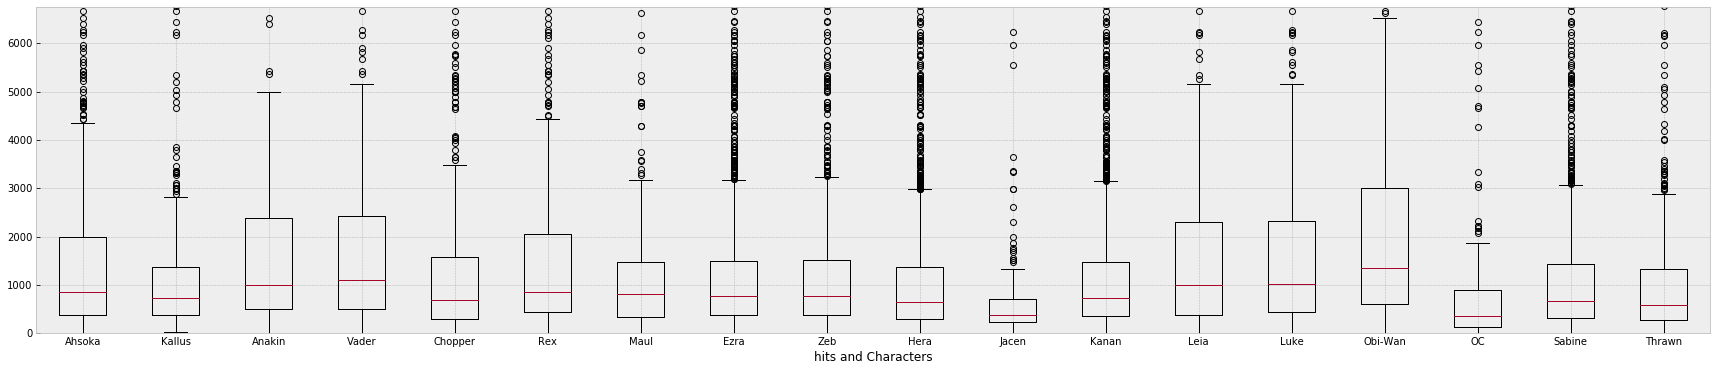

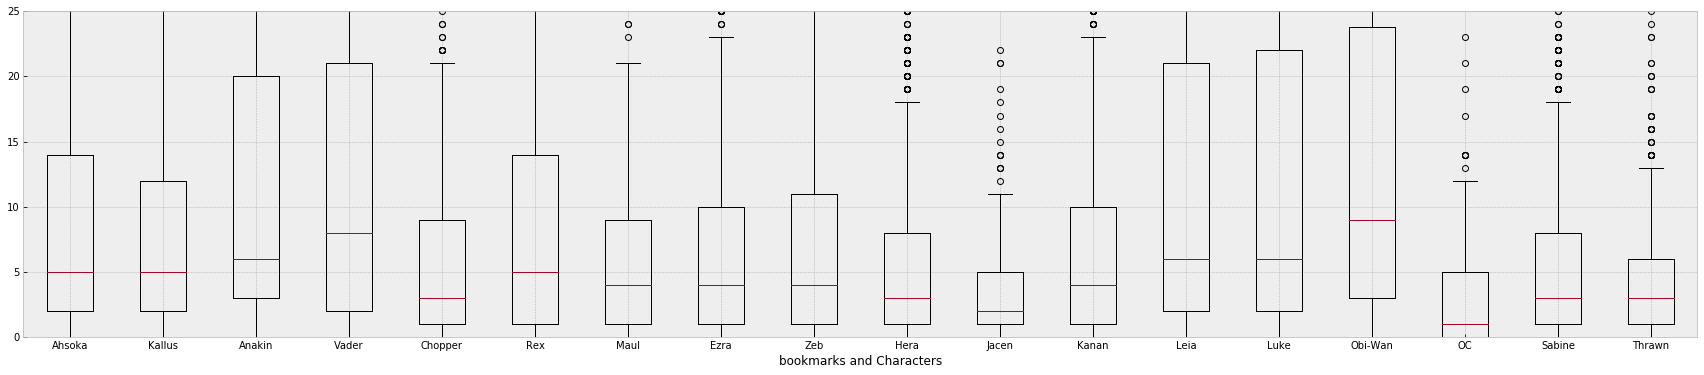

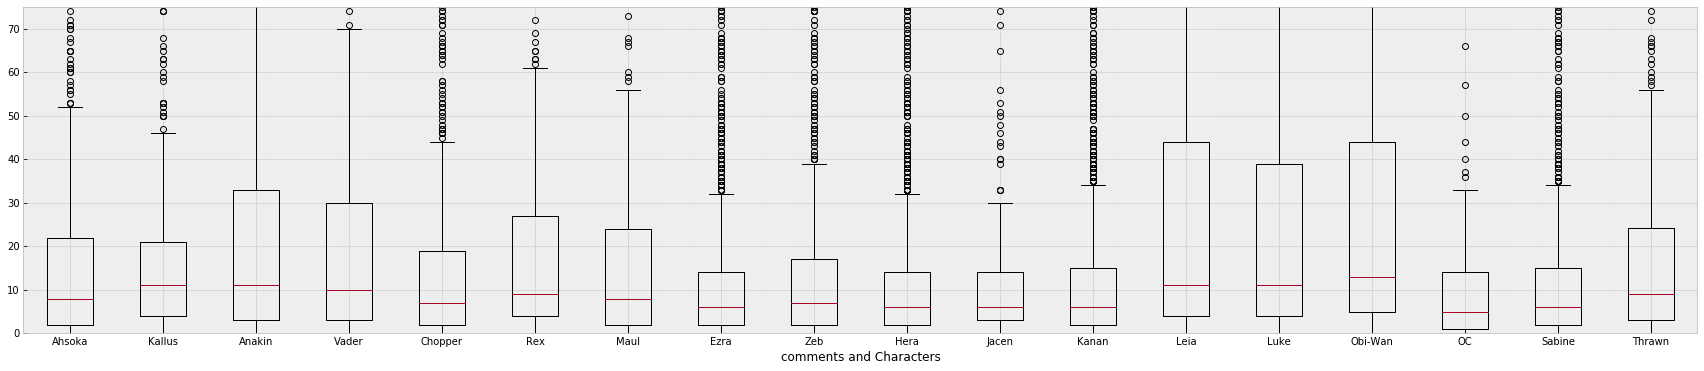

In [32]:
plot_character_interactions('kudos', 150)
plot_character_interactions('hits', 6750)
plot_character_interactions('bookmarks', 25)
plot_character_interactions('comments', 75)

### Interactions and Additional Tag

In [33]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['language']
language_df = one_hot_encoding(df, col_list, drop=True)
language_df.sum(axis = 0, skipna = True)


work_id                                                  54967815182
title              Second Chanceshurricane on the edge of oblivio...
rating             Teen And Up AudiencesMatureGeneral AudiencesGe...
category           M/M, F/FGenGenGenF/M, MultiF/F, F/M, M/MF/MGen...
fandom             Star Wars - All Media Types, Star Wars Prequel...
relationship       Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenob...
character          Leia Organa, Luke Skywalker, Anakin Skywalker,...
additional tags    Age Regression/De-Aging, Soul Bond, The Force,...
published          2015-01-052016-04-012017-02-022015-11-072015-0...
status             CompletedUpdatedCompletedCompletedCompletedCom...
status date        2016-04-162019-12-232017-12-272018-01-142018-1...
words                                                     34,627,299
chapters           42/4224/?8/855/5530/301/117/171/145/451/11/15/...
comments                                                      74,548
kudos                             

In [34]:
def plot_language_interactions(metric, ylim):
    # Top 3 languages

    np_ar1 = language_df[language_df['English'] == 1][metric].values
    np_ar2 = language_df[language_df['Polski'] == 1][metric].values
    np_ar3 = language_df[language_df['Russkii'] == 1][metric].values

    
    data_to_plot = [np_ar1, np_ar2, np_ar3]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['English', 'Polski','Russkii'])
    ax.set_xlabel(metric + ' and Languages')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

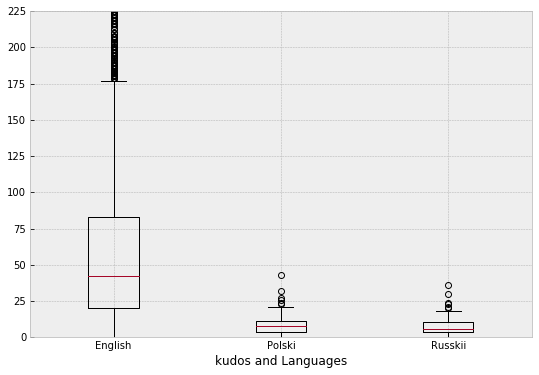

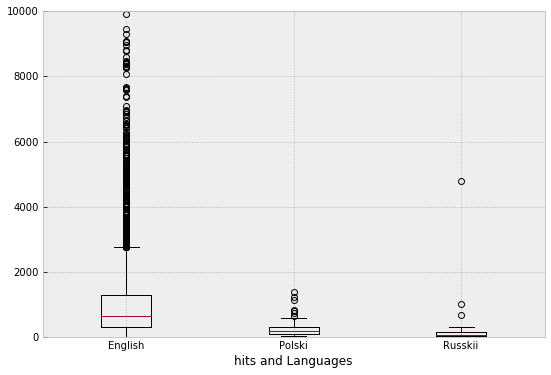

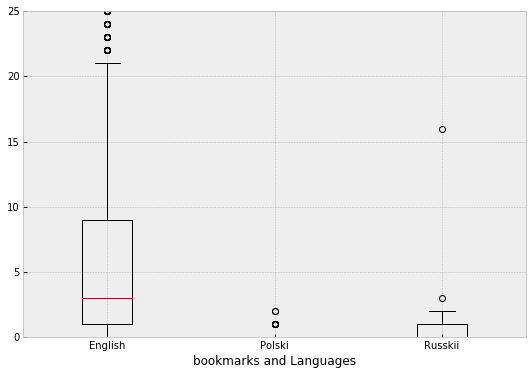

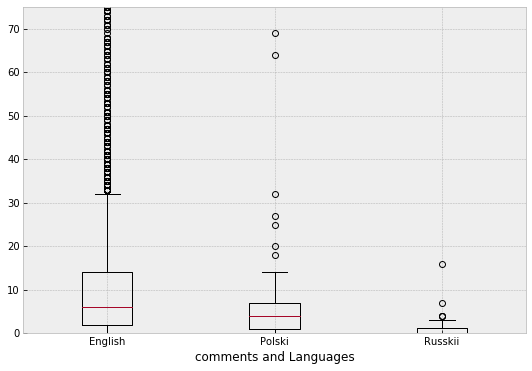

In [35]:
plot_language_interactions('kudos', 225)
plot_language_interactions('hits', 10000)
plot_language_interactions('bookmarks', 25)
plot_language_interactions('comments', 75)

### Interactions and Languages

In [36]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['language']
language_df = one_hot_encoding(df, col_list, drop=True)
language_df.sum(axis = 0, skipna = True)


work_id                                                  54967815182
title              Second Chanceshurricane on the edge of oblivio...
rating             Teen And Up AudiencesMatureGeneral AudiencesGe...
category           M/M, F/FGenGenGenF/M, MultiF/F, F/M, M/MF/MGen...
fandom             Star Wars - All Media Types, Star Wars Prequel...
relationship       Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenob...
character          Leia Organa, Luke Skywalker, Anakin Skywalker,...
additional tags    Age Regression/De-Aging, Soul Bond, The Force,...
published          2015-01-052016-04-012017-02-022015-11-072015-0...
status             CompletedUpdatedCompletedCompletedCompletedCom...
status date        2016-04-162019-12-232017-12-272018-01-142018-1...
words                                                     34,627,299
chapters           42/4224/?8/855/5530/301/117/171/145/451/11/15/...
comments                                                      74,548
kudos                             

In [37]:
def plot_language_interactions(metric, ylim):
    # Top 3 languages

    np_ar1 = language_df[language_df['English'] == 1][metric].values
    np_ar2 = language_df[language_df['Polski'] == 1][metric].values
    np_ar3 = language_df[language_df['Russkii'] == 1][metric].values

    
    data_to_plot = [np_ar1, np_ar2, np_ar3]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['English', 'Polski','Russkii'])
    ax.set_xlabel(metric + ' and Languages')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

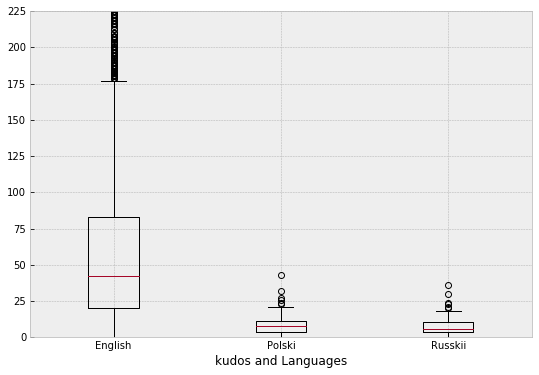

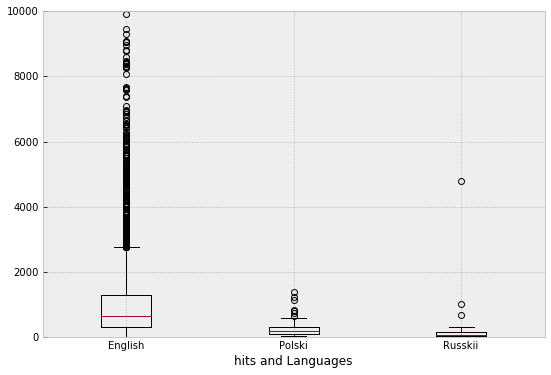

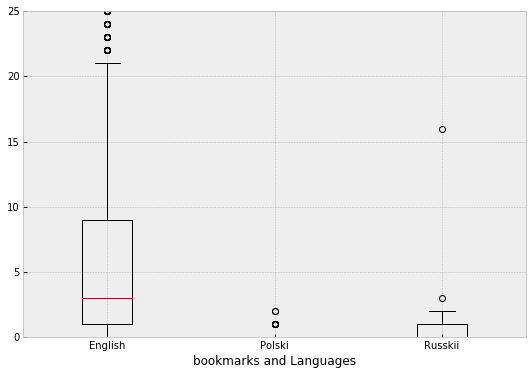

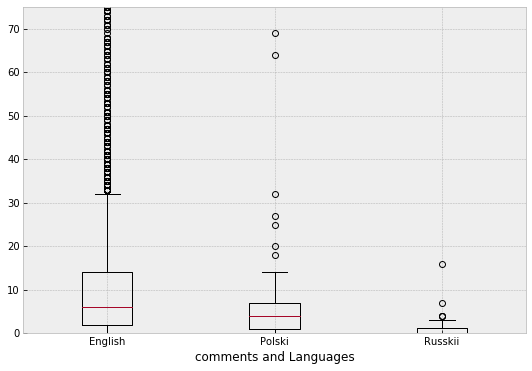

In [38]:
plot_language_interactions('kudos', 225)
plot_language_interactions('hits', 10000)
plot_language_interactions('bookmarks', 25)
plot_language_interactions('comments', 75)

### Interactions and Status

In [39]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['language']
language_df = one_hot_encoding(df, col_list, drop=True)
language_df.sum(axis = 0, skipna = True)


work_id                                                  54967815182
title              Second Chanceshurricane on the edge of oblivio...
rating             Teen And Up AudiencesMatureGeneral AudiencesGe...
category           M/M, F/FGenGenGenF/M, MultiF/F, F/M, M/MF/MGen...
fandom             Star Wars - All Media Types, Star Wars Prequel...
relationship       Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenob...
character          Leia Organa, Luke Skywalker, Anakin Skywalker,...
additional tags    Age Regression/De-Aging, Soul Bond, The Force,...
published          2015-01-052016-04-012017-02-022015-11-072015-0...
status             CompletedUpdatedCompletedCompletedCompletedCom...
status date        2016-04-162019-12-232017-12-272018-01-142018-1...
words                                                     34,627,299
chapters           42/4224/?8/855/5530/301/117/171/145/451/11/15/...
comments                                                      74,548
kudos                             

In [40]:
def plot_language_interactions(metric, ylim):
    # Top 3 languages

    np_ar1 = language_df[language_df['English'] == 1][metric].values
    np_ar2 = language_df[language_df['Polski'] == 1][metric].values
    np_ar3 = language_df[language_df['Russkii'] == 1][metric].values

    
    data_to_plot = [np_ar1, np_ar2, np_ar3]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['English', 'Polski','Russkii'])
    ax.set_xlabel(metric + ' and Languages')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

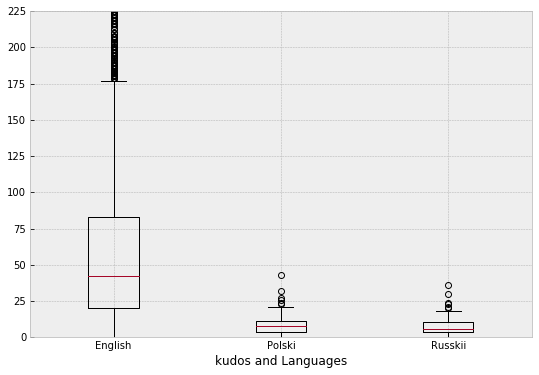

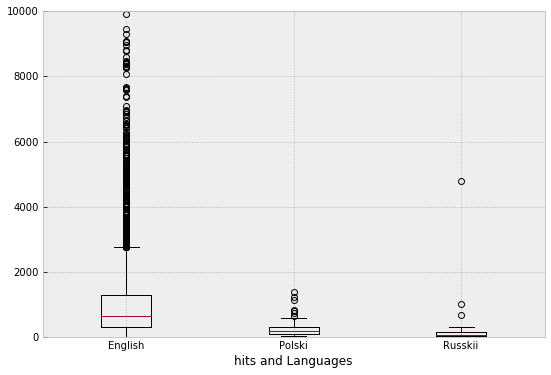

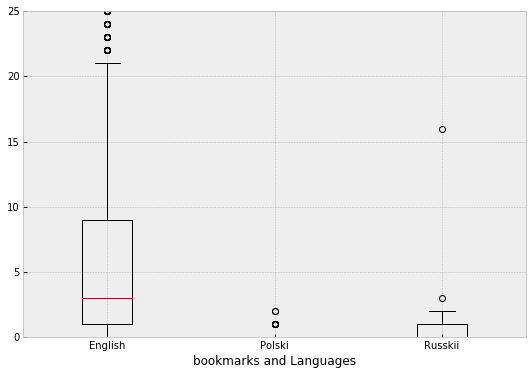

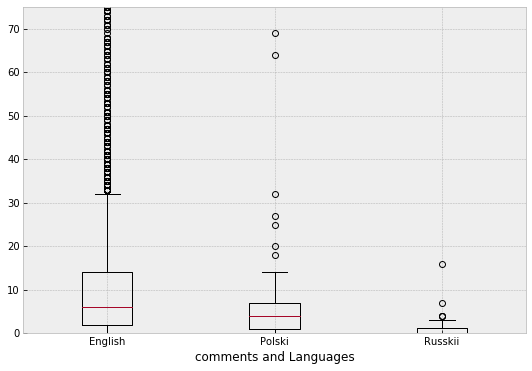

In [41]:
plot_language_interactions('kudos', 225)
plot_language_interactions('hits', 10000)
plot_language_interactions('bookmarks', 25)
plot_language_interactions('comments', 75)

### Interactions and Words

In [42]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['language']
language_df = one_hot_encoding(df, col_list, drop=True)
language_df.sum(axis = 0, skipna = True)


work_id                                                  54967815182
title              Second Chanceshurricane on the edge of oblivio...
rating             Teen And Up AudiencesMatureGeneral AudiencesGe...
category           M/M, F/FGenGenGenF/M, MultiF/F, F/M, M/MF/MGen...
fandom             Star Wars - All Media Types, Star Wars Prequel...
relationship       Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenob...
character          Leia Organa, Luke Skywalker, Anakin Skywalker,...
additional tags    Age Regression/De-Aging, Soul Bond, The Force,...
published          2015-01-052016-04-012017-02-022015-11-072015-0...
status             CompletedUpdatedCompletedCompletedCompletedCom...
status date        2016-04-162019-12-232017-12-272018-01-142018-1...
words                                                     34,627,299
chapters           42/4224/?8/855/5530/301/117/171/145/451/11/15/...
comments                                                      74,548
kudos                             

In [43]:
def plot_language_interactions(metric, ylim):
    # Top 3 languages

    np_ar1 = language_df[language_df['English'] == 1][metric].values
    np_ar2 = language_df[language_df['Polski'] == 1][metric].values
    np_ar3 = language_df[language_df['Russkii'] == 1][metric].values

    
    data_to_plot = [np_ar1, np_ar2, np_ar3]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['English', 'Polski','Russkii'])
    ax.set_xlabel(metric + ' and Languages')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

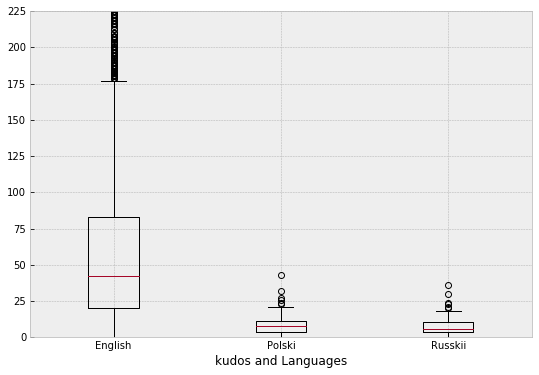

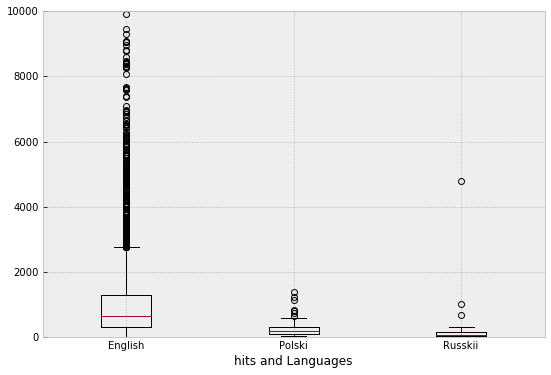

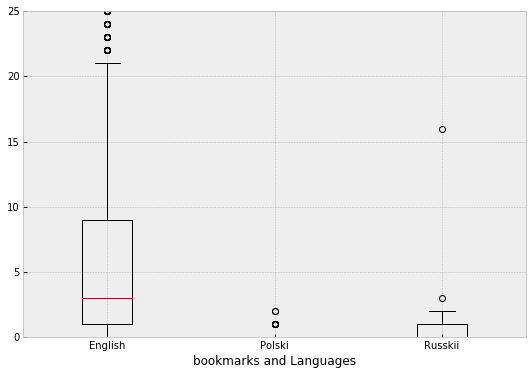

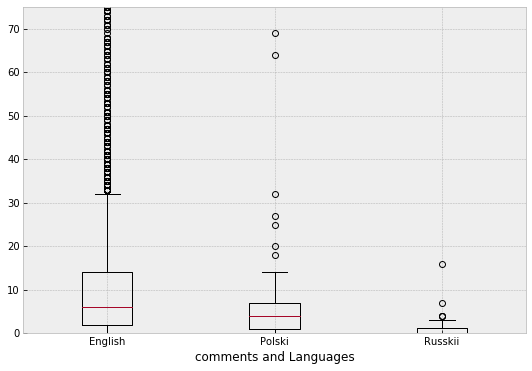

In [44]:
plot_language_interactions('kudos', 225)
plot_language_interactions('hits', 10000)
plot_language_interactions('bookmarks', 25)
plot_language_interactions('comments', 75)

### Interactions and Chapters

In [45]:
#col_list = ['rating', 'language', 'status', 'category', 'fandom', 'relationship', 'character', 'additional tags']
col_list = ['language']
language_df = one_hot_encoding(df, col_list, drop=True)
language_df.sum(axis = 0, skipna = True)


work_id                                                  54967815182
title              Second Chanceshurricane on the edge of oblivio...
rating             Teen And Up AudiencesMatureGeneral AudiencesGe...
category           M/M, F/FGenGenGenF/M, MultiF/F, F/M, M/MF/MGen...
fandom             Star Wars - All Media Types, Star Wars Prequel...
relationship       Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenob...
character          Leia Organa, Luke Skywalker, Anakin Skywalker,...
additional tags    Age Regression/De-Aging, Soul Bond, The Force,...
published          2015-01-052016-04-012017-02-022015-11-072015-0...
status             CompletedUpdatedCompletedCompletedCompletedCom...
status date        2016-04-162019-12-232017-12-272018-01-142018-1...
words                                                     34,627,299
chapters           42/4224/?8/855/5530/301/117/171/145/451/11/15/...
comments                                                      74,548
kudos                             

In [46]:
def plot_language_interactions(metric, ylim):
    # Top 3 languages

    np_ar1 = language_df[language_df['English'] == 1][metric].values
    np_ar2 = language_df[language_df['Polski'] == 1][metric].values
    np_ar3 = language_df[language_df['Russkii'] == 1][metric].values

    
    data_to_plot = [np_ar1, np_ar2, np_ar3]

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels(['English', 'Polski','Russkii'])
    ax.set_xlabel(metric + ' and Languages')
    ax.set_ylim([0, ylim])

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)

    # Save the figure
    fig.savefig('fig1.png', bbox_inches='tight')

    plt.show()

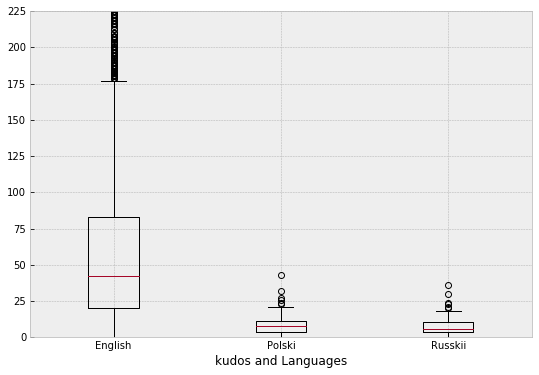

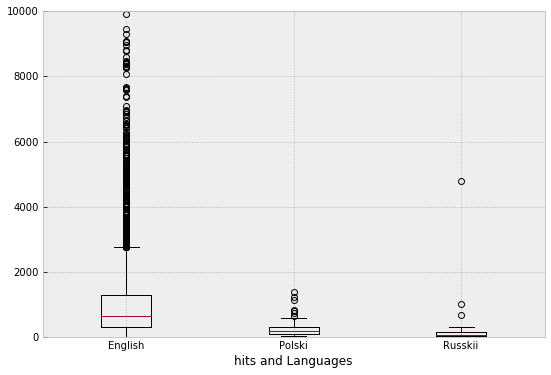

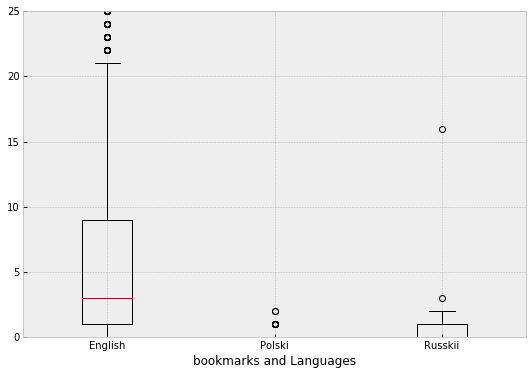

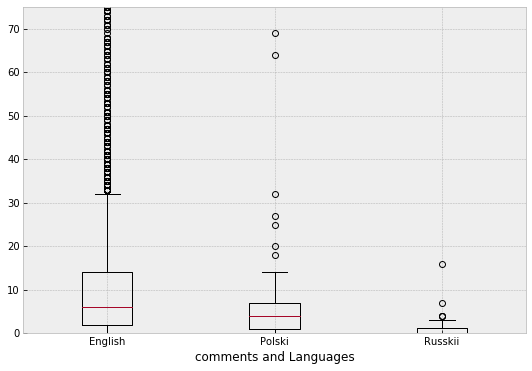

In [47]:
plot_language_interactions('kudos', 225)
plot_language_interactions('hits', 10000)
plot_language_interactions('bookmarks', 25)
plot_language_interactions('comments', 75)

## What is the shape of the data

Some general notes. One hot encoding all the categories will result in over 15k features, and a very sparse matrix. 

AO3 actually allows users to tag things as they like but a human will assign synonyms as they see fit. Its an unusual and powerful hyrbrid. Using the synonyms instead of user specified tag might result in a reduction of columns by perhaps a third? I'm not really sure without further scraping and possibly a database. For the near term, working to explore the data further might be most helpful.

# Feature Engineering

Quality vs popularity
Let's look at kudos, bookmarks, and comments and compare that to hits to get some quality metrics